# Imports and Paths

In [1]:
import os
import sys
from sklearn.ensemble import *
from copy import deepcopy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
    sys.path.append(PATH_func)
elif os.name == 'posix':
    PATH = '/home/msnow/git/data_science/'
    DATA = '/data/msnow/data_science/'
    sys.path.append(PATH+'src/')

In [5]:
from features.imports import *
from features.utilities import *
from features.fastai import * 

/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
pd.options.display.max_columns = 100

# Save to/Load from Feather

Load in the preprocessed dataset from the blue book for bulldozers kaggle competition

In [7]:
# df_raw.to_feather(f'{DATA}/bbfb/bulldozer')
df_raw = pd.read_feather(f'{DATA}/bbfb/bulldozer')
# df_raw_orig = pd.read_feather(f'{DATA}/bbfb/bulldozer_raw')

Split the data into the features and predictions for the random forest regressor

In [8]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [9]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200


Define a function to print out the relevant prediction scores from the random forest

In [59]:
def print_custom_RFscore(train=None,valid=None):
    if train is not None:
        train_rmse = custom_RFscore(m, X_train, y_train, score_func='rmse')
        train_score = m.score(X_train, y_train)
        print(f'Training   Score: {train_score:15.13}, rmse: {train_rmse:15.13}')
    if valid is not None:
        valid_rmse = custom_RFscore(m, X_valid, y_valid, score_func='rmse') 
        valid_score = m.score(X_valid, y_valid)
        print(f'Validation Score: {valid_score:15.13}, rmse: {valid_rmse:15.13}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB        Score: {m.oob_score_:15.13}')

In [29]:
n_trn = len(df)-12000
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

# $r^2$ and RMSE and scoring random forests

Let's run a simple random forest regressor on our dataset.  To create the random forest we are going to instatiate an instance the scikit-learn class of `RandomForestRegressor`, feed in our features and output and see how well it does at predicting that output

In [16]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
print_custom_RFscore(train=(df,y))

Training   Score:   0.9831248867037484, rmse: 0.08985783188356089


This score is the $r^2$ which is defined as :

$$r^2 = 1-\dfrac{SS_{res}}{SS_{tot}}  = 1-\dfrac{\sum\limits_i\left(y_i-f_i\right)^2}{\sum\limits_i\left(y_i-\bar{y}\right)^2}$$

where $y_i$ is the true output, $f_i$ is the model output and $\bar{y}$ is the mean true output.  Intepretation of different $r^2$ values is as follows
  1. $r^2 = 1$ means that the model perfectly predicts the output
  1. $r^2 = 0$ means the model does no better than predicting the output using the mean output, i.e., $\bar{y}$
  1. $1 > r^2 > 0 $ means that the model is better than simply using the mean ouptut
  1. $r^2 < 0$ means that the model is worse than just using the mean output as a predictor
 
However, $r^2$ by itself, is not a good metric as an overfit model will have an $r^2$ close to 1 for the training set, but would do much worse on a test set. 

To overcome the issue of overfitting, we can split the data into a training and validation set; using the training set to build the model and the validation set to test how good the model does on a different set of data.

In [14]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [17]:
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9831248867037484, rmse: 0.08985783188356089
Validation Score:   0.9845809963145277, rmse: 0.0929189233786401


What you can see here is that the validation set produces a higher $r^2$ score, which means that we are not voerfitting the data, but we have a slightly lower rmse score.  The reason why we are using an rmse, is because that is the metric that the kaggle competition is using.

# Speeding Things Up

To speed up the training and testing we can use a random subset of the data instead of using the entire dataset.  This is a good practice when you want to try out lots of idfferent models or play with the model settings.  When you are satisfied with your model and its parameters you can then go back and run it on the full dataset to make sure that your optimizations translate.  We only want to do this for the training set and not the validation set.

In [18]:
subset = 30000
trn_amount = 20000
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=subset, na_dict=na_dict, random_state=42)
X_train, _ = split_train_val(df_trn, trn_amount=trn_amount)
y_train, _ = split_train_val(y_trn, trn_amount=trn_amount)

In [19]:
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9713701793927434, rmse: 0.11740002087557172
Validation Score:    0.860582847441541, rmse: 0.2794049637390954


Our tests go much faster now than before, the downside though is that the model is less accurate than it was before.  Also, the decreased validation score (and increased rmse) as compared to the training scores indicates that we are overfitting on the training set. But if we can optimize the model for this subsampled dataset, then it should also improve the model for the full dataset as well.

# Decision Trees

To understand where these scores come from let's take a look at the output of a single tree, this can be set through the paramter `n_estimators`

In [20]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.4021924771094382, rmse: 0.5364627218288445
Validation Score:     0.42641122339384, rmse: 0.5667301731961657


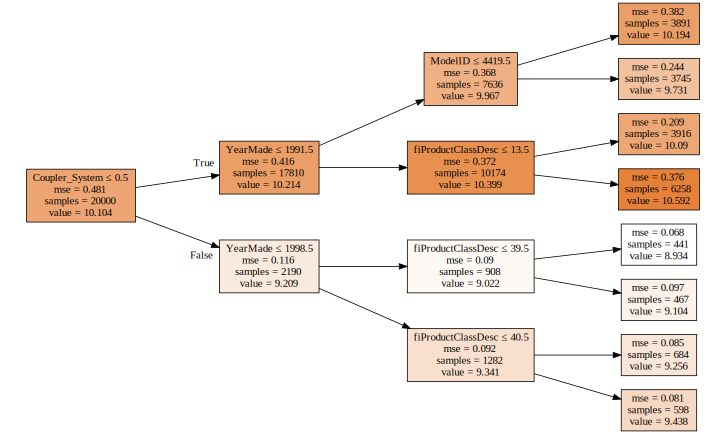

In [21]:
draw_tree(m.estimators_[0], df_trn, precision=3)

## Interpreting the Decision Tree

If I took the mean output of my entire dataset and used that to predict the output for each individual observation, what would the mean square error be?

In [21]:
mse = ((y_train - y_train.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train)}')
print(f'mean value = {round(y_train.mean(),3)}')

mean square error = 0.481
samples = 20000
mean value = 10.104


Taking a look at the tree above, we can now see that the `values` and `mse` term of the first node correspond to the mean output value and mean squared error using the output value of the entire dataset. Let's see if this analysis holds true for the next couple of nodes.

In [24]:
y_train_2_1 = y_train[list(X_train.Coupler_System <= 0.5)]
mse = ((y_train_2_1 - y_train_2_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_1)}')
print(f'mean value = {round(y_train_2_1.mean(),3)}')

mean square error = 0.416
samples = 17810
mean value = 10.214


In [25]:
y_train_2_2 = y_train[list(X_train.Coupler_System > 0.5 )]
mse = ((y_train_2_2 - y_train_2_2.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_2)}')
print(f'mean value = {round(y_train_2_2.mean(),3)}')

mean square error = 0.116
samples = 2190
mean value = 9.209


In [26]:
y_train_3_1 = y_train[list((X_train.Coupler_System <= 0.5)  & (X_train.YearMade <= 1991.5))]
mse = ((y_train_3_1 - y_train_3_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_3_1)}')
print(f'mean value = {round(y_train_3_1.mean(),3)}')

mean square error = 0.368
samples = 7636
mean value = 9.967


# Bagging

The problem with using a single tree is that the smaller the leaf nodes are, the more overfit the model is.  When the leaf nodes only have a single value in them, the model is perfectly predicts the training set but does not score nearly as high on the validation set

In [22]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:                  1.0, rmse: 6.023919126296978e-17
Validation Score:   0.7553853545920896, rmse: 0.3700984281858033


## Bagging Tutorial

To go from single decision trees to a random forest, you want to somehow combine multiple decision trees to end up with a result that is somehow better than any single decision tree.  This act of combining models to get a better model is called ensembling.  For the random forest, the idea being that you create lots of "bad" decision trees, where each one does contain some insight about your data as well as significantly overfitting the data (high score on training set, low score on validation set).  If you repeat this with lots of uncorrelated trees then their overfitting errors, which are randomly distributed, should average to zero, while retaining each individual tree's true information.

To uncorrelate the data we can randomly choose a subset of the data for each decision tree.

Lucky for us this is what scikit-learn does by default (this is the bootstrap parameter in the RandomForestRegressor (RFR)).  Technically, the RFR, picks out n_rows with replacement.  The term bagging is a portmanteau of Bootstrap aggregation.

To understand bagging let's take a look at how a prediction is made for a single sample across multiple trees.

In [33]:
m = RandomForestRegressor(n_estimators=3, max_depth=2, bootstrap=True, n_jobs=-1, max_features=0.5, random_state=42)
m.fit(X_train, y_train);

In [27]:
X_samp = X_valid.sample(1,random_state=42)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

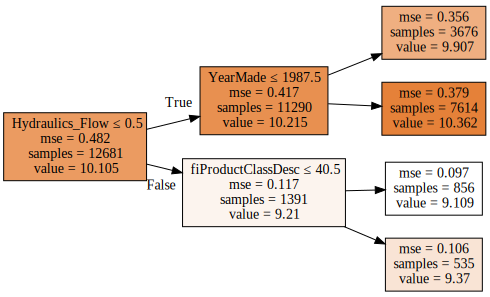

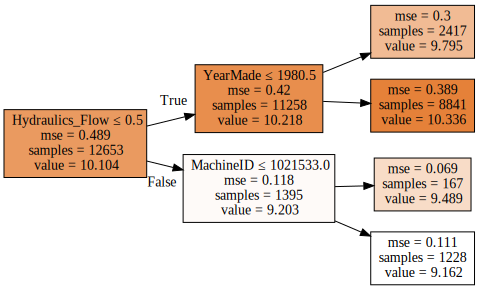

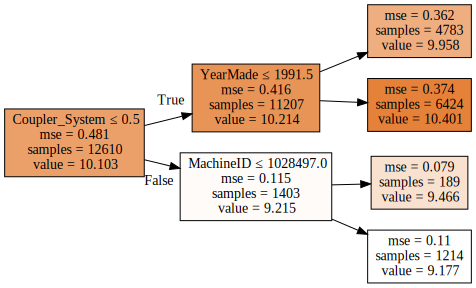

In [34]:
draw_tree(m.estimators_[0], df_trn, precision=3)
draw_tree(m.estimators_[1], df_trn, precision=3)
draw_tree(m.estimators_[2], df_trn, precision=3)

In [35]:
tree_features = []
for i in range(3):
    tree = m.estimators_[i].tree_
    tree_features += X_train.columns[tree.feature[tree.feature>0]].tolist()
tree_features = list(set(tree_features))    
X_pred = X_samp[tree_features].copy()
for i in range(3):
    X_pred['prediction'+str(i)] = np.round(preds[i,:],3)
X_pred

,fiProductClassDesc,Hydraulics_Flow,YearMade,Coupler_System,MachineID,prediction0,prediction1,prediction2
391060,69,0,2007,0,2288268,10.362,10.336,10.401


Following the nodes for each of the trees

1. Hydraulics_Flow < 0.5 --> YearMade > 1987.5 --> value = 10.362
1. Hydraulics_Flow < 0.5 --> YearMade > 1980.5 --> value = 10.336
1. Coupler_System < 0.5 --> YearMade  > 1991.5 --> value = 10.401

Comparing the average prediction for each sample to the output of the predict function gives the same result. This demonstrates how the random forest computes the prediction for each sample.

In [36]:
print(f'Average prediction: {np.mean(preds,axis=0)}')
print(f'Predict function: {m.predict(X_samp)}')

Average prediction: [10.36653151]
Predict function: [10.36653151]


Since the errors are randomly distributed, in theory, the predictions from the trees should form a normal distribution.

In [37]:
m = RandomForestRegressor(n_estimators=1000, bootstrap=True, n_jobs=-1, max_features=0.5, random_state=42)
m.fit(X_train, y_train);
X_samp = X_valid.sample(1)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

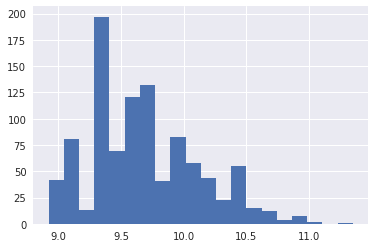

In [38]:
plt.hist(preds, bins=20);

### Prediction Confidence

Bagging averages the predictions across many trees, but how confident can we be in this prediction?  If the predictions are all relatively similar this would engender more confidence than if the predictions were  from a much broader distribution.  This can be quantified by calculating the standard deviation of the prediction.  The smaller the ratio of the standard deviation to the average prediction the more confident you can be in your prediction

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9538937886218072, rmse: 0.14898363945558693
Validation Score:   0.8721286897588398, rmse: 0.2675854966478357
OOB        Score:   0.8499681954984574


In [40]:
def get_preds(t): return t.predict(X_valid)
preds = np.stack(parallel_trees(m, get_preds))

In [41]:
raw_train, raw_valid = split_train_val(df_raw, n_trn)
x = deepcopy(raw_valid)
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x['counts'] = 1
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
# summ = x[flds].groupby(flds[0]).agg({'SalePrice':['mean', 'count'],'pred':'mean','pred_std':'mean'})
summ['counts'] = x[['ProductSize','counts']].groupby(flds[0]).count()
summ

,SalePrice,pred,pred_std,counts
ProductSize,,,,
Compact,9.735093,9.927339,0.400789,143
Large,10.470589,10.369832,0.371603,297
Large / Medium,10.691871,10.658255,0.298430,1706
Medium,10.681511,10.661650,0.304909,1549
Mini,9.535147,9.560640,0.236533,1369
Small,10.324448,10.333036,0.319647,624


In [42]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.040372
Large             0.035835
Small             0.030934
Medium            0.028599
Large / Medium    0.028000
Mini              0.024740
dtype: float64

What you can see here is that they all have relatively similar ratios and the size of the ratio correlates with the number of counts of the feature.  This strengthens our belief that the prediction is valid.

## Number of bagged trees

Starting with the basic model, we can demonstrate how the predictive ability of the RF model increases with the number of ensembled decision trees

In [43]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9709349395263148, rmse: 0.11828903155793125
Validation Score:   0.8595824782971763, rmse: 0.2804055884719159


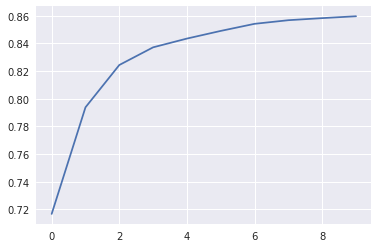

In [44]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Let's see how the validation score improves as a function of the number of tree

In [45]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9707309369003428, rmse: 0.11870343079388265
Validation Score:   0.8573625310714246, rmse: 0.28261344880228717


In [46]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=20)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:    0.976477603112339, rmse: 0.10641421544381106
Validation Score:   0.8675893240788645, rmse: 0.2722936504623168


In [47]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9788653649102491, rmse: 0.10086865678778076
Validation Score:   0.8741740803300826, rmse: 0.26543676128660953


In [48]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=80)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9801100577000249, rmse: 0.09785333289875224
Validation Score:   0.8762740953139342, rmse: 0.2632123920581164


You can see that the validation score does improve, but there are diminishing returns

## Out-of-Bag (OOB) score 

You can see in the cases above that even with the bagging and increasing the number of trees, the validation score is still significantly lower than the training score.  This often means that we are overfitting the model.  But maybe the validation set is just statistically different than the training set, in which case the validation score will always be lower.  To test this possibility we can do something call Out-of-Bagging (OOB).  

When using bagging, we are only selecting n-rows for each tree.  For example, if there are 20 trees built, row 1 could be used only in trees 1, 7, 13, and 15.  If that's the case, then tree 2 was not trained using row 1 and so it can be used as a validation set for tree 2.  This is what OOB does, it uses each row as part of the validation set, but only for the trees which did not use it to train.  Since the OOB validation set comes from same data as the training set, any difference is scores is due to overfitting and not statistically distinct sets.

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.9786973424747392, rmse: 0.10126882091612802
Validation Score:   0.8726366238321669, rmse: 0.26705351245253733
OOB        Score:   0.8490205490882097


Practically, the oob score slightly underestimates the generalizability of the model, but this decreases as a function of the number of samples.

In this case you can see that the oob score is very similar to the validation score, which confirms that the drop in score is most probably due to overfitting and not different distributions.

# Reducing Overfitting and Random Forests

## Subsampling

To make the random forest faster, I subsampled from the original dataset 20,000 rows, and then built all of my decision trees, with boostrapping and oob_score, on those subset of rows.  An alternative is to build each tree from a sample of 20,000 rows, from my entire dataset, for each tree.  This allows you to take advantage of a faster model (less samples) while accessing a larger training and validation set.

In [90]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_train_val(df_trn, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)

In [51]:
set_rf_samples(20000)

In [52]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.8788869746529911, rmse: 0.24072877914874174
Validation Score:   0.8662673917286429, rmse: 0.27364950728041876
OOB        Score:   0.8662470793907298


In [55]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:    0.891998225124203, rmse:    0.227325436292213
Validation Score:    0.877342372140895, rmse:    0.262073611603122
OOB        Score:    0.880475310096569


Now you can see that while our validation and oob_scores have not improved, the training score has decreased.  While this might seem like a bad thing, what this implies is that now, we are no longer ovrefitting the model.

Be aware that currently, the oob score still only looks at the unused rows of the sample set, not the entire dataset.

## Tree Building Parameters

To demonstrate the improvement of modifying the RFR options, I am going to go back to using the original parameters

In [56]:
reset_rf_samples()
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:    0.987172384256892, rmse:   0.0783439668873558
Validation Score:    0.900012676879312, rmse:    0.236618383877459
OOB        Score:    0.908337567515315


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

 - There are less decision rules for each leaf node; simpler models should generalize better
 - The predictions are made by averaging more rows in the leaf node, resulting in less volatility (and higher confidence)

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:    0.972310409402144, rmse:    0.115104116113134
Validation Score:     0.90305065441593, rmse:    0.232995993934637
OOB        Score:    0.908347079127035


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

 - None
 - 0.5
 - 'sqrt'
 - An integer value, e.g., 1, 3, 5

In [92]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score: 0.9702994712778, rmse: 0.1192105460408
Validation Score:  0.907076133022, rmse: 0.2281075448791
OOB        Score:  0.911795389906


This property of selecting a subset of the features, is the difference between decision trees with bagging and random forests. The statistical motiviation for this method is that without random sampling of the features at each split, if one or a few features are very strong predictors they will be preferentially selected, resulting in correlated trees.  Correlated trees, when averaged, do not reduce the variance nearly as well as the average of many uncorrelated trees.

# Feature Importance

## Overview

In addition to being able to make accurate predictions it is important to be able to identify which factors are the most important in making that prediction.

In [61]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [62]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score: 0.9838684334268, rmse: 0.08932969597416
Validation Score: 0.8147236593066, rmse: 0.3220964923098
OOB        Score:  0.884364033527


The RFR stores the feature importances for every feature in a variable appropriately named `m.feature_importances_`.  The values are the relative importance of each feature and they sum to 1.

In [63]:
sum(m.feature_importances_)

1.0

Matching the values to their columns and showing the top 10

In [64]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
37,Coupler_System,0.261521
19,Enclosure,0.203290
5,YearMade,0.091259
13,ProductSize,0.056620
10,fiSecondaryDesc,0.053154
14,fiProductClassDesc,0.052996
2,ModelID,0.043482
63,saleElapsed,0.042848
1,MachineID,0.035106
8,fiModelDesc,0.025293


Plotting the importance as bars lets you easily see natural cutoffs in feature importance

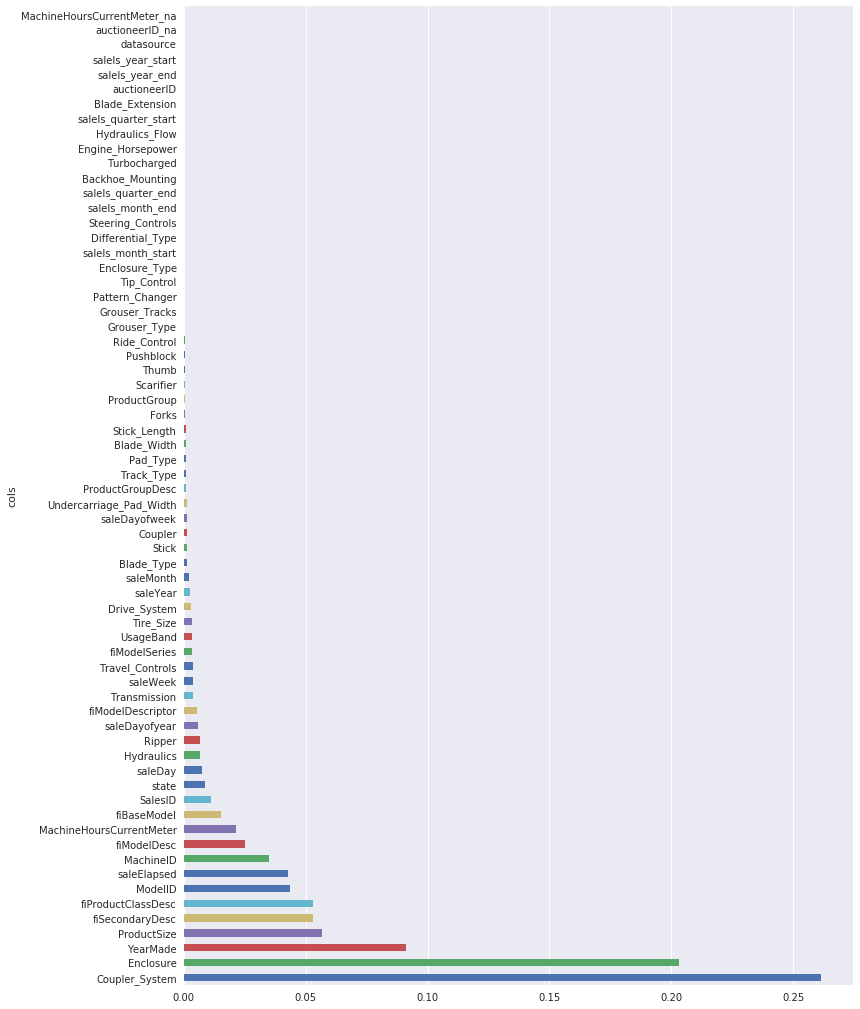

In [65]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,18), legend=False, grid=True);
ax.yaxis.grid(False)

What happens if we run a RFR using only the most "important" features

In [81]:
to_keep = fi[fi.imp>0.005].cols;
df_keep = df_trn[to_keep].copy()
_, X_valid = split_train_val(df_keep,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
X_train, _ = split_train_val(df_keep, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [82]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score: 0.9632717414873, rmse: 0.1347900243616
Validation Score: 0.8286530052382, rmse: 0.3097520996369
OOB        Score: 0.8886628453164


This shouldn't make nuch of a difference in the predictor, maybe just a slight increase.  What happens if we plot the feature importance using only the "important" features

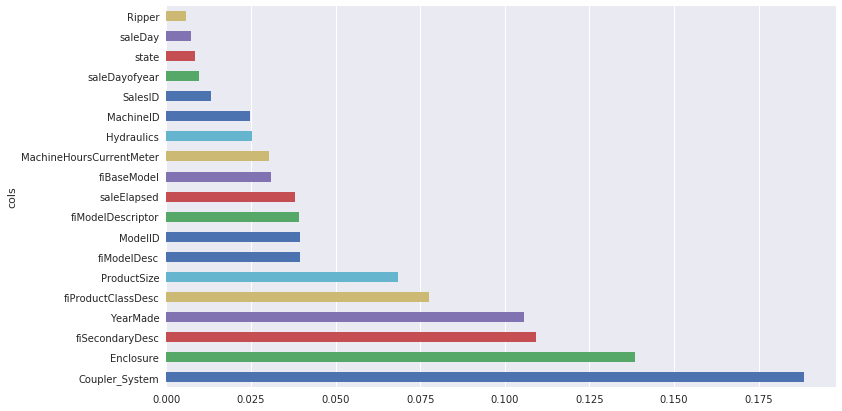

In [83]:
fi = rf_feat_importance(m, df_keep)
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

You can see that the importance of certain features has changed.

## Calculating the feature importance ??????????

One way to determine the importance of any feature is to take that feature and mix up all its values and see how much the score decreases by.  I will be using less samples, just to make the calculations go faster (if slightly less accurate).

In [95]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_train_val(df_trn,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False, min_samples_leaf=9)
m.fit(X_train, y_train)
Score_orig = (m.score(X_train, y_train),m.score(X_valid, y_valid))
Score_orig

(0.9999999999957294, 0.7990585279201616)

In [130]:
smp_sz = 40000
df_small = df_raw.sample(smp_sz,random_state=42)
df, y, na_dict = proc_df(df_small, 'SalePrice')

In [149]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=True, min_samples_leaf=9)
m.fit(X_train, y_train)
Score_orig = (m.score(X_train, y_train),m.score(X_valid, y_valid))
Score_orig

(0.9116163188588868, 0.8532882027452973)

In [94]:
n_trn

389125

In [54]:
fi = rf_feat_importance(m, df_trn)
feat_list = fi.iloc[:,0].tolist()

In [135]:
X_train.shape

(40000, 66)

In [153]:
X_feat = X_train.copy()
X_feat[feat_list[0]] = X_feat[feat_list[0]].sample(len(X_feat),random_state=42)
m.fit(X_feat, y_train)
(Score_orig[0] - m.score(X_feat, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(-0.0003737334203067766, -0.0005571893310599707)

In [148]:
X_feat = X_train.copy()
X_feat[feat_list[25]] = X_feat[feat_list[25]].sample(len(X_feat),random_state=42)
m.fit(X_train, y_train)
(Score_orig[0] - m.score(X_train, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(-0.0003147761753081735, -0.0011365767246251934)

In [93]:
df_feat = df_raw.copy()
df_feat[feat_list[25]] = df_feat[feat_list[25]].sample(trn_amount,random_state=42)
df_trn, y_trn, nas = proc_df(df_feat, 'SalePrice')
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
X_train, _ = split_train_val(df_trn, trn_amount)
y_train, _ = split_train_val(y_trn, trn_amount)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False)
m.fit(X_train, y_train)
(Score_orig[0] - m.score(X_train, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(0.0, 0.0005362142958822425)

## When to be wary of feature importance/feature engineering

1. overfitting the model (oob_score should decrease if overfitting)
1. Finding something true about the training data which is not true about the validation data, e.g., time series data in which the training data is randomly sampled but validation data is not random, but a specific time period.

## One hot encoding

Let's say you are trying to predict which type of car sells the best and the most importanct factor is the size of the car, e.g., minicompact, subcompact, compact, mid-size, and large.  More specifically, let's say that whether a car is mid-size or not is the best predictor of the number of sales.  You were diligent in your preprocessing and ordered the categorical variables where applicable, so that when transformed to a numeric column the sizes match up as follows:

 - unknown = 0
 - minicompact = 1
 - subcompact = 2
 - compact = 3
 - mid-size = 4
 - large = 5

In order for the RF to parse this property it has to make two splits, e.g., size less thna / greater than 4.5 and size less than / greater than 3.5.  The only real issue with needing multiple splits to get at a single value is it wastes splits.  Since the most splits possible for any RF model is the $\log_2(d)$, where $d$ is the number of variables, every 10 fold increase in $d$ only increases the total split count by about 3.  So even if there are 1,000 variables, you can only do about 10 splits.  So wasting them is not ideal.

This is where one-hot encoding comes in. Instead of representing all options as different values in one column, you split out each value into its own binary variable.  So in the car sizes example, one column would be weather the car is a minicompact, another would be, whether the car is a subcompact, and so on.  This shouldn't take the model that much longer to process as there are still the same number of values just spread out over multiple columns.  The downside of one-hot encoding is that if there is a a split in the values, such as all cars subcompact or smaller, sell really well, then one-hot encoding requires more splits than the standard RF.  However, this issue only appears when the data is first properly organized for every value, and when the desired values are contiguous.  If the values are not continguous, either due to a lack fo proper ordering or because the values that matter are dissimilar, then one-hot encoding does the better job.  For example in the car case if subcompacts and mid-size cars sold the best, then the stanrd RF has to make 4 splits to tease that out, while the ohe-hot encoded RF only has to make 2 splits. There are two factors to be aware of with one-hot encoding

1. The number of columns can get ridiculous. 
1. The maximum number of unique values per variable to one-hot encode.  For example if you set this at 7 and a variable had 8 possible values, it would not one-hot encode it.  This mitigates the issues created by the first factor.  

In [93]:
n_trn = len(df_raw)-12000
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_train_val(df_trn2, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score: 0.9699322319239, rmse:  0.119945285583
Validation Score: 0.9027272489362, rmse: 0.2333842866303
OOB        Score: 0.9105175813562


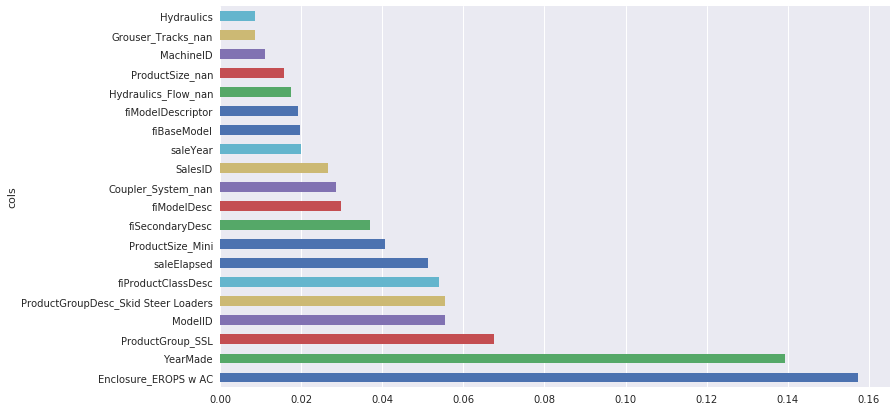

In [94]:
fi = rf_feat_importance(m, df_trn2)
ax = fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

## Detecting redundant features

Sometimes you can have multiple features that repeat the same information to the model.  For example let's say I was modeling car sales and two of my variables were car size class and number of seats.  These two variables are expressing the same underlying property of the car and as a result are veyry highly correlated.  

These types of features are a problem because they can dilute the importance of each feature individually.  For example if in half the models the RF split on number of seats and half the time it split on car size, the relative importance of the underlying feature would be reduced by half.  So you want a method of detecting redundant features.

One way of doing this is through a dendrogram.

In [86]:
from scipy.cluster import hierarchy as hc

Note that in the graphs below, I used the spearman rank correlation and not the standard pearson correlation.  The reason for this switch is left as an exercise for the reader.  Just joking.  The standard pearson's correlation assesses a linear relationship between two continuous variables without outliers (typically defined as $\pm 3.29$ $sd$ away from the mean).  Since random forests typically deal with both a mix of ordinal and continuous variables the spearman rank correlation is preferred.  The spearman rank correlation essentailly just ranks the $n$ values along each axis from 1 (lowest value along that axis) to $n$ (highest value along that axis) and then effectively calculates the correlation on the ranks.  So regardless of the shape of the data points along the graph, if an increase in $x$ always produces and increase in $y$ then the spearman rank correlation will be 1. 

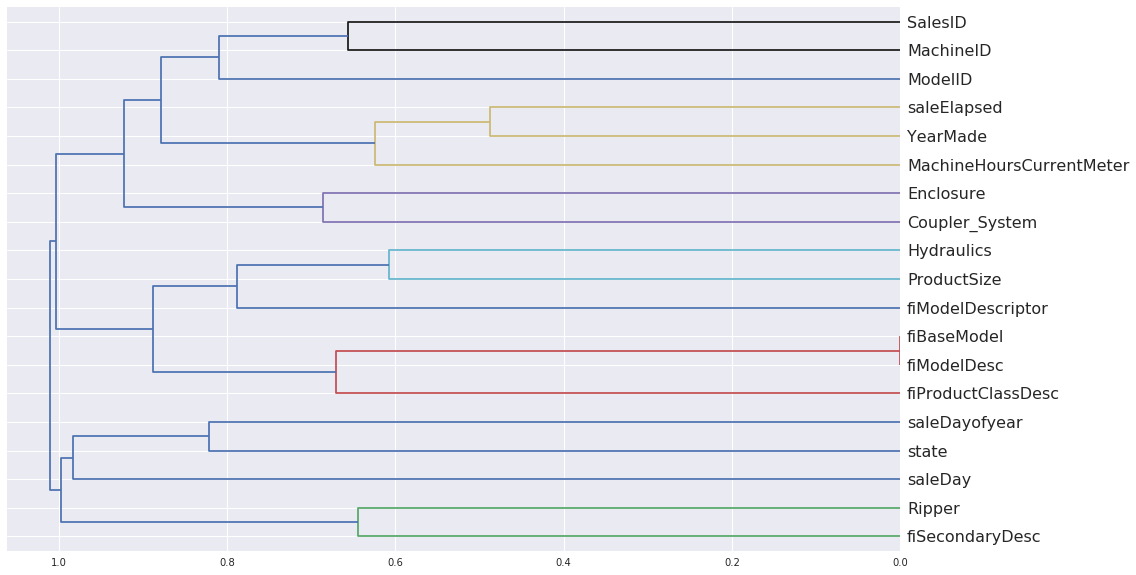

In [95]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

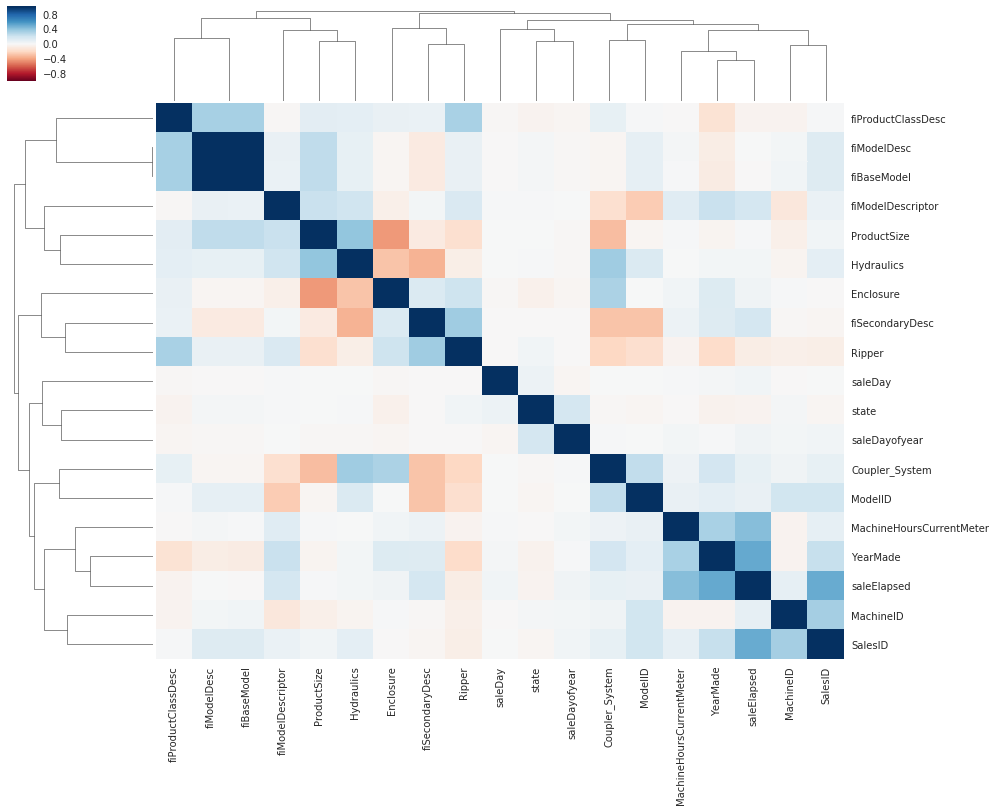

In [96]:
g = sns.clustermap(corr,xticklabels=df_keep.columns,yticklabels=df_keep.columns,figsize=(15,12),cmap='RdBu',vmin=-1,vmax=1)

To quantify the degree to which removing each of these "redundant" features affect the RF, i can remove one at a time and evaluate the resulting oob_score.  

In [97]:
corr_list = []
corr_tuple = []
thresh = 0.5
corr_fill = np.copy(corr)
np.fill_diagonal(corr_fill,0)
for i,v in pd.DataFrame(corr_fill,index=df_keep.columns,columns=df_keep.columns).iterrows():
    if len(v[v>thresh] > 0):
        corr_list.append(i) 
        corr_list += (v[v>thresh]).index.tolist()
        corr_tuple += [i,(v[v>thresh]).index.tolist()]
corr_set = set(corr_list)
corr_set

{'SalesID', 'YearMade', 'fiBaseModel', 'fiModelDesc', 'saleElapsed'}

In [98]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=9, max_features=0.6, n_jobs=-1, oob_score=True, random_state=42)
    x, _ = split_train_val(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [99]:
print(get_oob(df_keep))
for i in corr_set:
    print(i, get_oob(df_keep.drop(i, axis=1)))

0.9030391043055852
fiModelDesc 0.9018282019879602
YearMade 0.8875932553530269
fiBaseModel 0.9016158233927603
saleElapsed 0.8436425056760987
SalesID 0.9027288874397066


In [100]:
corr_tuple

['YearMade',
 ['saleElapsed'],
 'saleElapsed',
 ['YearMade', 'SalesID'],
 'fiModelDesc',
 ['fiBaseModel'],
 'fiBaseModel',
 ['fiModelDesc'],
 'SalesID',
 ['saleElapsed']]

Looking at the changes in oob_score I can drop `fiBaseModel`, `fiModelDesc`, and `SalesID` only have a 3rd decimal point difference in oob_score.  But rememeber I need to always keep one feature from every redundant set, which I can see using the `corr_tuple` variable.  So it looks like I can drop `SalesID` as well as either `fiBaseModel` or `fiModelDesc`.

Let's see what happens to the oob_score when I drop those columns

In [102]:
to_drop = ['SalesID', 'fiBaseModel']
get_oob(df_keep.drop(to_drop, axis=1))

0.9019079813231613

In [104]:
to_drop = ['SalesID', 'fiModelDesc']
get_oob(df_keep.drop(to_drop, axis=1))

0.9024271183666077

Let's create a new dataframe of columns to keep, dropping these redundant features.

In [105]:
to_drop = ['SalesID', 'fiModelDesc']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_train_val(df_keep, n_trn)

In [106]:
reset_rf_samples()

In [107]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True, random_state=42)
m.fit(X_train, y_train)
print_custom_RFscore(train=(X_train,y_train),valid=(X_valid,y_valid))

Training   Score:   0.96493144785, rmse: 0.1295363050474
Validation Score: 0.9086568116629, rmse: 0.2261591151516
OOB        Score: 0.9083416908926


# Feature Interpretation

## Partial Dependence Plotting

Let's now take a look at how some of the features with the highest importance relate to the outcome of interest

In [108]:
set_rf_samples(50000)

In [109]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_train_val(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, random_state=42)
m.fit(X_train, y_train);

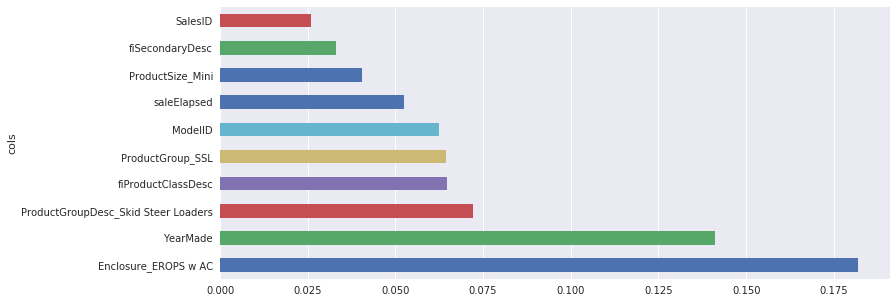

In [110]:
fi = rf_feat_importance(m, df_trn2); 
ax = fi[:10].plot('cols', 'imp', 'barh', figsize=(12,5), legend=False, grid=True);
ax.yaxis.grid(False)

`YearMade` seems to be one of the most important features.  How does that relate to the sale price

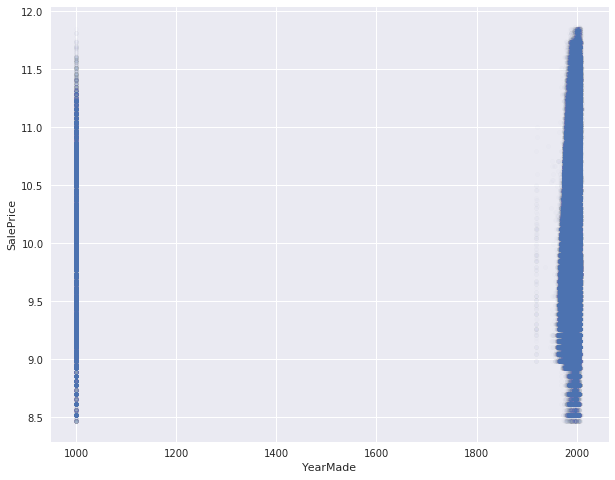

In [111]:
df_raw.plot('YearMade','SalePrice','scatter',alpha=0.01, figsize=(10,8))

The first thing to notice is that there seems to be a lot of vehicles made in the year 1000.  This probably means that vehicles manufactured before a certain date or vehicles without a year made entry are just given the value of 1000.  Let's replot this data, but only looking at valid `YearMade` entries

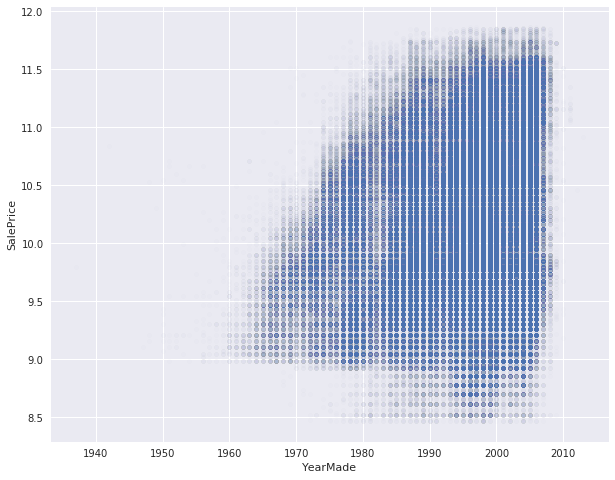

In [112]:
df_raw[df_raw.YearMade>1930].plot('YearMade','SalePrice','scatter',alpha=0.01, figsize=(10,8))

There definitely does seem to be some relationship between `YearMade` and `SalePrice`.  In order to visualize this data in a more meaningful way, let's take a look at the average `SalePrice` as a function of `YearMade` and plot that along with its standard deviation. To do that I am going to use the plotnine package, which is a python implementation of the R plotting package ggplot.  Within ggplot there is a plot called stat_smooth, which plots the average and standard deviation using a smoothing function and here we are using the `loess` setting which tells it to fit a polynomial surface to the data in local regions, i.e., take each chunk of points and fit a polynomial to that section only.

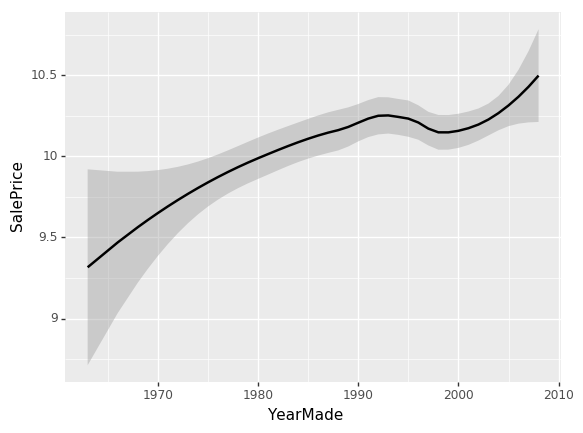

<ggplot: (-9223363251426057991)>

In [116]:
x_all = df_raw[df_raw.YearMade>1930].sample(500, random_state=50)
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

A cursory analysis of this data seems to imply that `SalePrice` rose steadily besides for a dip in the late 1990's.  But is this actually true.  There are lots of variables which influence the `SalePrice`, if we kept all of them constant except for `YearMade` would we still see the same trend.

To get at this we can use a package called [pdpbox](https://github.com/SauceCat/PDPbox).  This package was built to help understand the realtionships between predictors and outcomes.  As the package says in its documentation: 
> For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. 

The way pdpbox works is that it for each value of a specific feature (or value percentiles for continuous values more than the threshold), it creates a new dataset where all the other features are the same, but the feature of interest is kept constant.  Predictions are made for that value of the feature of interest.  This is repeated for all values.  What you end up with is for every observation you have the predicted outcome as a function of every value in the feature of interest. 

For example, let's say we have the following dataset, where `Var2` is our feature of interest and `Outcome` is the predicted outcome.

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1      | V1_1      |  V2_1 |
| O2      | V1_2      |  V2_2 |
| O3      | V1_3      |  V2_3 |

pdpbox creates 3 new datasets

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(1)      | V1_1(1)      |  V2_1 |
| O2(1)      | V1_2(1)      |  V2_1 |
| O3(1)      | V1_3(1)      |  V2_1 |

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(2)      | V1_1(2)      |  V2_2 |
| O2(2)      | V1_2(2)      |  V2_2 |
| O3(2)      | V1_3(2)      |  V2_2 |

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(3)      | V1_1(3)      |  V2_3 |
| O2(3)      | V1_2(3)      |  V2_3 |
| O3(3)      | V1_3(3)      |  V2_3 |

You can then plot the outcomes for each observation as a function of Var2

| V2_1 | V2_2      | V2_3  |
| --------|:---------:| -----:|
| O1(1)      | O1(2)      |  O1(3) |
| O2(1)      | O2(2)      |  O2(3) |
| O3(1)      | O3(2)      |  O3(3) |


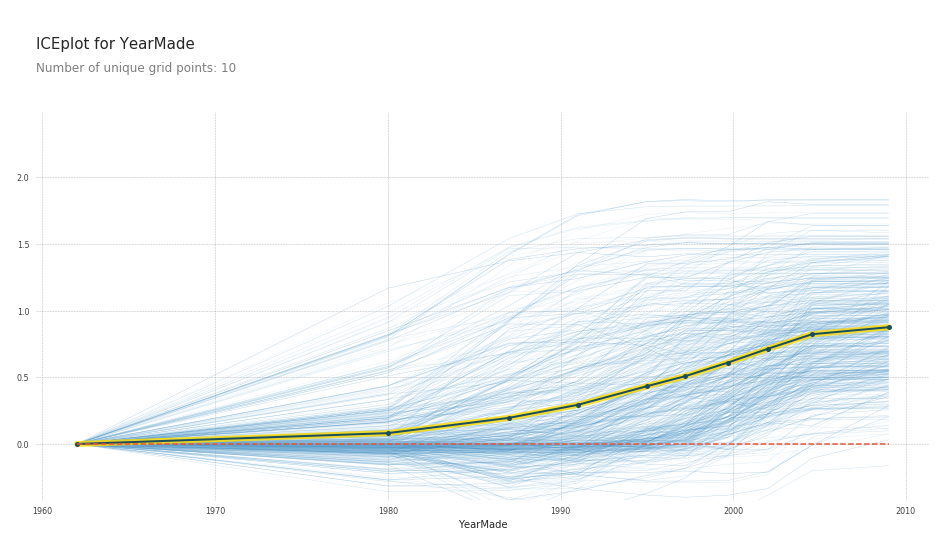

In [118]:
feat_name = 'YearMade'
x_trn = X_train[X_train[feat_name]>1930].sample(500, random_state=50)
p = pdp.pdp_isolate(m, x_trn, feat_name)
pdp.pdp_plot(p, feat_name, plot_lines=True)
# plot_pdp(,x_trn)

This demonstrates that as `YearMade` increases, so does sale price, and correcting for other variables we no longer see that dip in the late 1990's.

In addition to the individual lines, pdp also plots the average prediction for each value.  

We can also cluster the lines to parse out possible specific trends

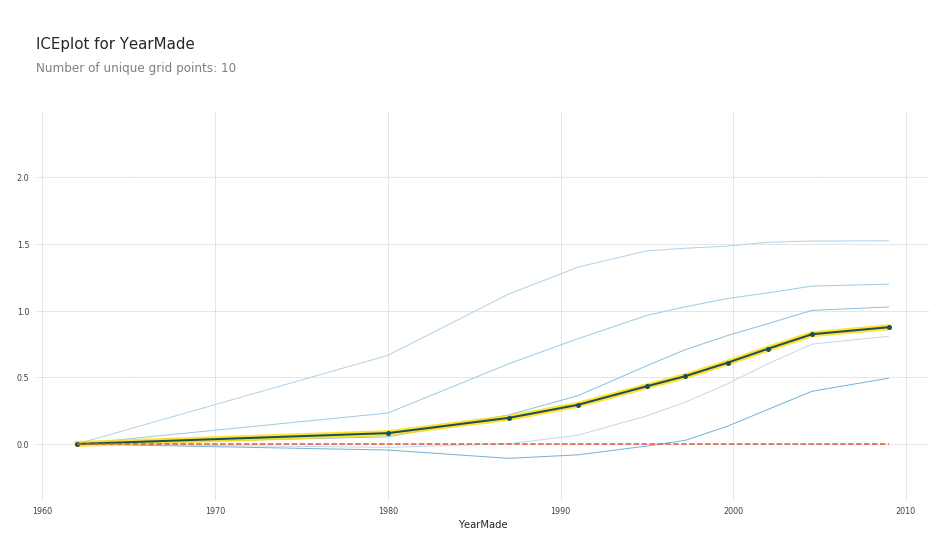

In [119]:
pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=True, n_cluster_centers=5)

The shape of the clustered lines indicate that there are not different subgroups with different trends, the shape is similar across all observations.

We can also look at a two-way comparison between the the age of the item and when it was sold

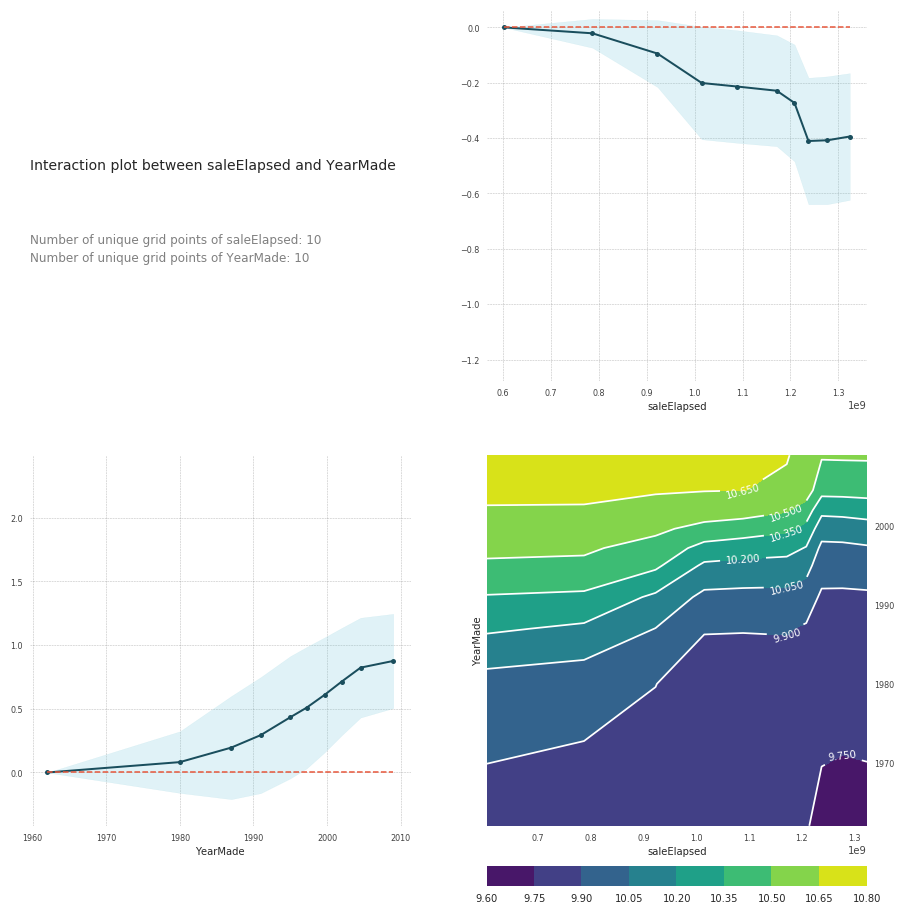

In [120]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x_trn, feats)
pdp.pdp_interact_plot(p, feats)

In [122]:
df_raw2 = df_raw.copy()
df_raw2.YearMade[df_raw2.YearMade<1950] = 1950
df_keep2 = df_keep.copy()
df_keep2['age'] = df_raw2['age'] = df_raw2.saleYear-df_raw2.YearMade

In [123]:
X_train, X_valid = split_train_val(df_keep2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, random_state=4)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

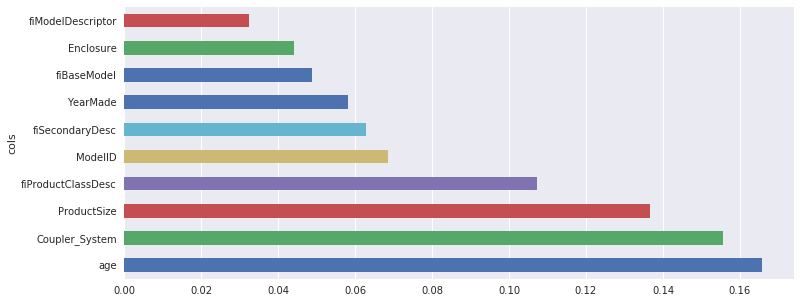

In [125]:
fi = rf_feat_importance(m, df_keep2)
ax = fi[:10].plot('cols', 'imp', 'barh', figsize=(12,5), legend=False, grid=True);
ax.yaxis.grid(False)

## Tree Interpreter

First let's take a look back at our individual trees

In [126]:
from treeinterpreter import treeinterpreter as ti

In [132]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')
df_train, df_valid = split_train_val(df[df_keep.columns], n_trn)
df_raw_train, df_raw_valid = split_train_val(df_raw[df_keep.columns], n_trn)

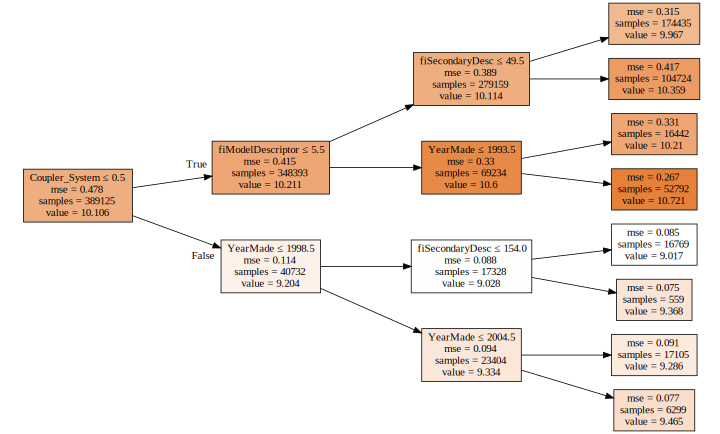

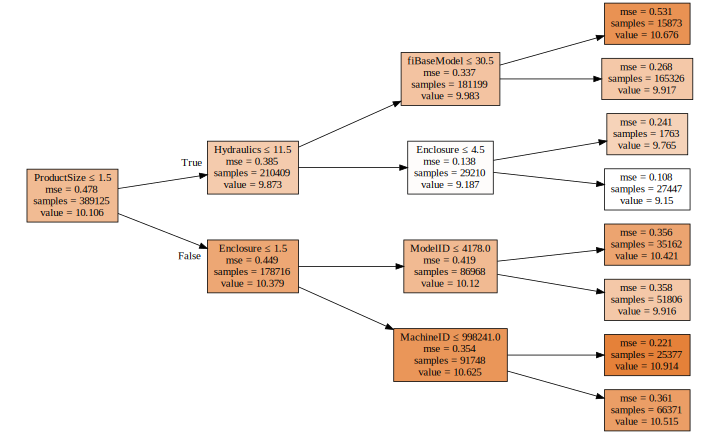

In [142]:
m = RandomForestRegressor(n_estimators=2, max_depth=3, bootstrap=False, n_jobs=-1, max_features=0.5, random_state=42)
m.fit(df_train, y_train)
draw_tree(m.estimators_[0], df_train, precision=3)
draw_tree(m.estimators_[1], df_train, precision=3)

These are the trees that will be applied to our validation set.  Let's look at the values for the first validation observation and its prediction

In [148]:
df_valid.iloc[0,:].astype(int)

Coupler_System                       0
Enclosure                            1
YearMade                          1999
ProductSize                          5
fiSecondaryDesc                      0
fiProductClassDesc                  17
ModelID                            665
saleElapsed                 1284595200
MachineID                      2300944
MachineHoursCurrentMeter          3726
fiBaseModel                       1111
state                               35
saleDay                             16
Hydraulics                          12
Ripper                               0
saleDayofyear                      259
fiModelDescriptor                    0
Name: 389125, dtype: int64

In [149]:
m.predict(df_valid.values[None,0,:])

array([10.19422151])

Let's track the validation observation node by node for each tree.  Remember that value in the tree is the mean value of the outcome, in this case SalePrice, in the training set.

**Tree 1**

1. Starting values
  - mean: 10.106 
  - change: 0
1. Coupler_System < 0.5
  - mean: 10.211
  - change: 0.105 (10.211 - 10.106)
1. fiModelDescriptor < 5.5
  - mean: 10.114
  - change: -0.097
1. fiSecondaryDesc < 49.5
  - mean: 9.967
  - chage: -0.147

**Tree 2**

1. Starting values
  - mean: 10.106 
  - change: 0
1. ProductSize > 1.5
  - mean: 10.379
  - change: 0.273
1. Enclosure < 1.5
  - mean: 10.12
  - change: -0.259
1. ModelID < 4178
  - mean: 10.421
  - chage: 0.301

The predicted outcome for this observation is the average of the final values, i.e., 10.47 and 9.967, which is 10.2185, which matches the value we get using the built in predictor.  We can calculate how each feature contributed to the outcome for this observation by averaging the change across trees.

- Coupler_System = (0.105 + 0) / 2 = 0.0525
- fiModelDescriptor = (-0.097 + 0) / 2 = -0.0485
- fiSecondaryDesc = (-0.147 + 0) / 2 = -0.0735
- ProductSize = (0 + 0.273) / 2 = 0.1365
- Enclosure = (0 + -0.259) / 2 = -0.1295
- ModelID = (0 + 0.301) / 2 = 0.1505

You can then average these effects over all observations to see which features have the greatest impact on the predicted output and how they relate.

Instead of doing this all by hand there is a handy package called tree interpreter which does all of these calculations for you.  Given a model and a set of observations to predict upon, tree interpreter outputs the starting value of the model the ending value for each observation and the contribution of each feature for each observation.  This is useful when you want to understand what features were important in the output of the model for data besdies for the training data. Your testing data might contain data different than the testing set, and so you want to be able to pinpoint which features the model used to determine the predicted outcomes.

Tree interpreter is also useful in understanding where your predictions come from.  For example, if you make a prediction about a patient, you can go back and understand what features about that patient led to that prediction, e.g., weight, temperature, WBC.

In [151]:
prediction, bias, contributions = ti.predict(m, df_valid)
df_ti = pd.DataFrame(contributions, columns = df_valid.columns)

Let's see if our calculations match the output of tree interpreter

In [152]:
df_ti.iloc[0,:]

Coupler_System              0.052697
Enclosure                  -0.129717
YearMade                    0.000000
ProductSize                 0.136948
fiSecondaryDesc            -0.073518
fiProductClassDesc          0.000000
ModelID                     0.150506
saleElapsed                 0.000000
MachineID                   0.000000
MachineHoursCurrentMeter    0.000000
fiBaseModel                 0.000000
state                       0.000000
saleDay                     0.000000
Hydraulics                  0.000000
Ripper                      0.000000
saleDayofyear               0.000000
fiModelDescriptor          -0.048210
Name: 0, dtype: float64

Let's look at the features sorted by which have the greatest effect on the model's output.  Remember though, that this only tells us which features are important for the validation set's output, and does not directly correspond to the features overall importance.

In [153]:
df_ti.abs().sum()

Coupler_System              1717.419899
Enclosure                    723.573526
YearMade                     434.009354
ProductSize                 1510.221363
fiSecondaryDesc              633.354840
fiProductClassDesc             0.000000
ModelID                      267.633458
saleElapsed                    0.000000
MachineID                    248.336065
MachineHoursCurrentMeter       0.000000
fiBaseModel                  293.322301
state                          0.000000
saleDay                        0.000000
Hydraulics                   486.898476
Ripper                         0.000000
saleDayofyear                  0.000000
fiModelDescriptor            827.741149
dtype: float64

As expected, since our validation set is just a split of our original data set, the features  that were important for the training data are also important in the validation set.  

We can also take a look at the relationship between feature values and effect on output, to see if this makes logical sense.

<Figure size 1080x720 with 0 Axes>

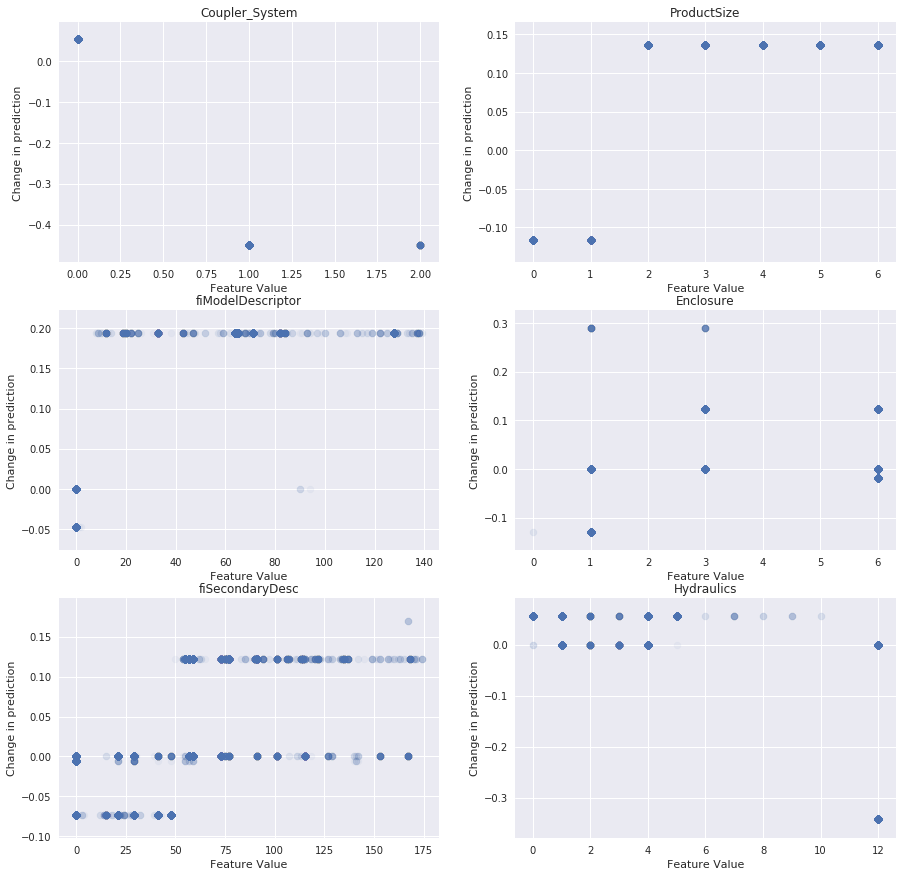

In [154]:
plt.figure(figsize=(15,10))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
col_ranked = df_ti.abs().sum().sort_values(ascending=False).index.tolist()
ct = 0
for ax in axes.flat[0:]:
    ax.scatter(df_valid[col_ranked[ct]],df_ti[col_ranked[ct]], alpha=0.05)
    ax.set_title(col_ranked[ct])
    ax.set_ylabel('Change in prediction')
    ax.set_xlabel('Feature Value')
    ct+=1

# Extrapolation

Linear models have one big advantage over RFs, cases where there are linear dependencies, specifically time dependence.  For example if you measure the temperature from January to June and want to predict July, a linear relationship 

This is to determine if you can predict which samples are in your validation set based on your training set. Unless your variagbles are time dependent, then you shouldn't be able to determine which samples are in the validation set and and which are in the training set. 

In [634]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [635]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9953381115612341

The high value of the $r^2$ indicates that whether or not the observaion is in the validation set is predictable.  Let's try to understand which features are important in this prediction.

In [636]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
5,saleElapsed,0.433080
9,MachineID,0.237105
15,auctioneerID,0.088068
4,ModelID,0.058772
7,fiModelDesc,0.041570
13,saleDayofyear,0.028225
14,saleDayofweek,0.017186
8,fiSecondaryDesc,0.014887
3,fiProductClassDesc,0.012503
1,YearMade,0.012367


`SaleElapsed` is an integer veraile we created out of the sale date, which tracks time.  So it makes sense that it is very important in predicting the validation set.  `MachineID` might seem like a weird feature to be time dependent, but it probably means that they label the machines sequeuntially, so machines made later have ID's with larger values.  This is probalby why the nextmost important features are ID's as well.

Let's analyse these two top features a little more in depth

In [640]:
feats = ['saleElapsed','MachineID']

In [644]:
(X_train[feats]/1000).describe()

,saleElapsed,MachineID
count,3.891250e+05,389125.000000
mean,1.084797e+06,1206.796148
std,1.803913e+05,430.850552
min,6.009984e+05,0.000000
25%,9.666432e+05,1087.016000
50%,1.134605e+06,1273.859000
75%,1.234138e+06,1458.661000
max,1.325117e+06,2313.821000


In [645]:
(X_valid[feats]/1000).describe()

,saleElapsed,MachineID
count,1.200000e+04,12000.000000
mean,1.306609e+06,1578.049709
std,2.497808e+04,589.497173
min,1.174522e+06,0.830000
25%,1.309219e+06,1271.225250
50%,1.316045e+06,1825.317000
75%,1.321402e+06,1907.858000
max,1.325203e+06,2486.330000


You can see that the mean values of these features in the validation set are significantly larger than in the training set, which makes sense for temporally dependent variables.  

So let's remove these variables and retrain the RF.

In [646]:
x.drop(feats, axis=1, inplace=True)

In [647]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9818884387659708

In [648]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
14,age,0.212109
1,YearMade,0.175109
11,saleDayofyear,0.150538
4,ModelID,0.076489
13,auctioneerID,0.068894
6,fiModelDesc,0.063183
8,saleDay,0.050192
12,saleDayofweek,0.048077
9,state,0.047599
3,fiProductClassDesc,0.033343


Removing and rerunning allows other time dependent features to come to the forefront, so let's add them to our feature list and remove them from the data set.

In [656]:
feats = ['saleElapsed','MachineID','age','YearMade','saleDayofyear']

In [650]:
set_rf_samples(50000)

In [653]:
X_train, X_valid = split_train_val(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.21073711399308534
Validation rmse: 0.24688452213699602
Training Score: 0.9071852749599562
Validation Score: 0.8911481783661365
OOB Score: 0.890426833953384


Let's see how the model changes as I drop each one of these time-dependent features. Hoepfully, our score should increase as we remove time dependent features, as the model needs to use other aspects of the dataset to predict the outcomes.

In [657]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_train_val(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_custom_RFscore()

saleElapsed
Training rmse: 0.21613710289099486
Validation rmse: 0.2545605542412998
Training Score: 0.9023677095791692
Validation Score: 0.884274200524617
OOB Score: 0.8849761342083278
MachineID
Training rmse: 0.20909427413632378
Validation rmse: 0.24644790793031207
Training Score: 0.9086267428139185
Validation Score: 0.8915328458726508
OOB Score: 0.8926467811518966
age
Training rmse: 0.21047684362465402
Validation rmse: 0.2441553308668586
Training Score: 0.9074143945938906
Validation Score: 0.8935414868951138
OOB Score: 0.8907182987185611
YearMade
Training rmse: 0.2108961936208036
Validation rmse: 0.25102154301840435
Training Score: 0.9070450955255325
Validation Score: 0.8874695738171886
OOB Score: 0.8902579486858592
saleDayofyear
Training rmse: 0.210717838787551
Validation rmse: 0.24417355323949907
Training Score: 0.9072022529003939
Validation Score: 0.8935255953798049
OOB Score: 0.8907712286709283


Our OOB score shouldn't change as that is drawn from the training data, but the validation score should improve for any truly time depedent variables, which when removed require the model to use other factors to predict the outcome.

What you can see is that removing some of them do help (`age`,`saleDayofyear`), some of them make no difference (`MachineID`) and some make the model worse (`saleElapsed`,`YearMade`).  So let's see what happens when we remove those features.

In [658]:
reset_rf_samples()

In [660]:
df_subs = df_keep.drop(['age', 'saleDayofyear'], axis=1)
X_train, X_valid = split_train_val(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.13166758367000078
Validation rmse: 0.22344658075388948
Training Score: 0.9637679791795063
Validation Score: 0.9108347974066389
OOB Score: 0.9074077069497573


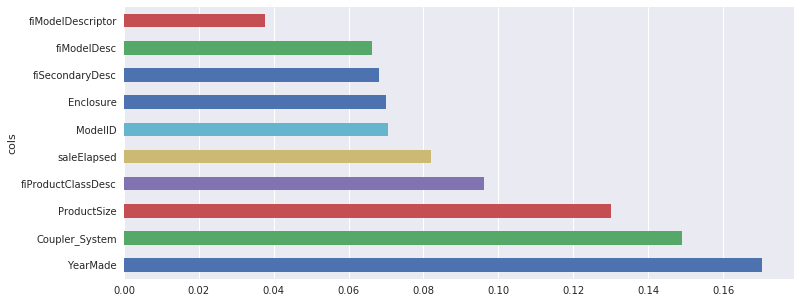

In [661]:
fi = rf_feat_importance(m, X_train); 
ax = fi[:10].plot('cols', 'imp', 'barh', figsize=(12,5), legend=False, grid=True);
ax.yaxis.grid(False)

Now our validation score is higher than our OOB.  So let's rerun the model, but let it work through with lots of trees and see how good we can get. 

# Final Model

In [662]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.0750266185556487
Validation rmse: 0.21730127937213836
Training Score: 0.9882357140382388
Validation Score: 0.9156718562772781
OOB Score: 0.9141811648706994


# RF with very large datasets

This dataset is from the kaggle competition [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting).  And has been munged in the data_munging notebook

In [13]:
g_raw = pd.read_feather(f'{DATA}favorita/groceries')

ArrowException: Unknown error: 

In [92]:
df_g, y_g, na_dict = proc_df(g_raw, 'unit_sales')

In [ ]:
n_valid = 3370464 # size of the test set
n_trn = len(g_raw) - n_valid
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)